In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import meta stock data from 4/2022 to 4/2023
meta = pd.read_csv('META_STOCK_42023_42022.csv', index_col='Date')
meta.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-04,225.979996,234.350006,225.860001,233.889999,233.889999,28054800
2022-04-05,234.080002,236.860001,231.020004,231.839996,231.839996,29727200
2022-04-06,226.910004,228.990005,221.410004,223.300003,223.300003,28995100
2022-04-07,223.929993,225.520004,218.559998,222.949997,222.949997,21037200
2022-04-08,222.380005,225.130005,220.029999,222.330002,222.330002,18375700


In [3]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 2022-04-04 to 2023-04-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       251 non-null    float64
 1   High       251 non-null    float64
 2   Low        251 non-null    float64
 3   Close      251 non-null    float64
 4   Adj Close  251 non-null    float64
 5   Volume     251 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7+ KB


In [4]:
meta.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,160.271315,163.604542,157.528128,160.472908,160.472908,3.444629e+07
std,33.190317,33.780537,32.371741,33.036430,33.036430,2.200091e+07
min,90.080002,90.459999,88.089996,88.910004,88.910004,1.200760e+07
25%,132.909996,136.885002,131.579994,133.339996,133.339996,2.342220e+07
50%,164.800003,167.759995,161.300003,163.729996,163.729996,2.862520e+07
75%,185.855004,190.010002,181.959999,184.704994,184.704994,3.681175e+07
max,234.080002,236.860001,231.020004,233.889999,233.889999,2.323166e+08


# Strategy by fast and slow signal and Moving Average

In [5]:
#create profit differance in 2 day --> appli shift
meta['PriceDiff'] = meta['Close'].shift(-1) - meta['Close']
meta.tail()

,Open,High,Low,Close,Adj Close,Volume,PriceDiff
Date,,,,,,,
2023-03-28,200.149994,201.029999,197.899994,200.679993,200.679993,19127300,4.670013
2023-03-29,203.559998,205.720001,202.539993,205.350006,205.350006,18851100,2.489990
2023-03-30,203.380005,208.089996,202.820007,207.839996,207.839996,22608300,4.100006
2023-03-31,207.240005,212.169998,206.770004,211.940002,211.940002,25412000,1.130005
2023-04-03,208.839996,213.490005,208.199997,213.070007,213.070007,17908100,NaN


In [6]:
#Create return daily column
# return = PriceDiff/close
meta['Return'] = meta['PriceDiff']/meta['Close']

In [7]:
#Create direction column with condition with proffit daily
#Price differance > 0 --> Up 1 --> positive
# Price differance <= 0 --> -1 --> negative
meta['Direction'] = [1 if meta.loc[ei,'PriceDiff']>0 else -1 for ei in meta.index]

A moving average is a widely used signal in stock trading, which is loading average price over a defined number of days. Random flutuations are very common in stcok price. Taking an average price in a peroid can smooth out noise. It is sought to be good to find the trend.

- MA40 is a moving average Close price over 40 days
- MA200 is a moving avg Close price over 200 days

In [8]:
#Create moving average column MA40 and MA 200
meta['MA40'] = meta['Close'].rolling(40).mean()
meta['MA200'] = meta['Close'].rolling(200).mean()

In [9]:
import matplotlib.pyplot as plt

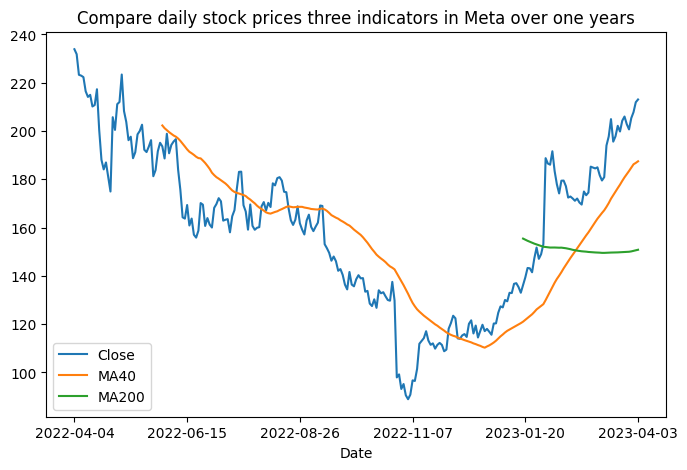

In [10]:
#Create plot to compare MA40, MA200 to Close price
plt.figure(figsize= (8,5))
meta['Close'].plot()
meta['MA40'].plot()
meta['MA200'].plot()
plt.legend()
plt.title('Compare daily stock prices three indicators in Meta over one years')
plt.show()

MA40 is a fast signal and MA200 is a slow signal, which reflects the price over a long history.

If MA40 is above MA200, some trades ,who are trend-following traders, believe the stock price will move upwards for a while.

If MA40 is up MA200 traders buy and hold one share of stock.


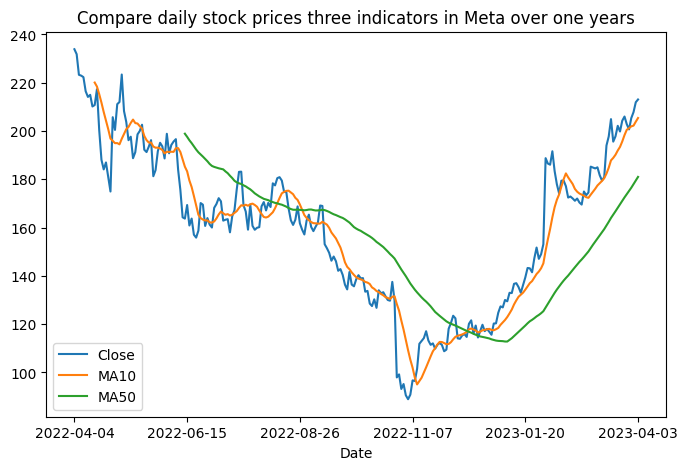

In [11]:
meta['MA10'] = meta['Close'].rolling(10).mean()
meta['MA50'] = meta['Close'].rolling(50).mean()
plt.figure(figsize= (8,5))
meta['Close'].plot()
meta['MA10'].plot()
meta['MA50'].plot()
plt.legend()
plt.title('Compare daily stock prices three indicators in Meta over one years')
plt.show()

In [12]:
# Long or not?
# Create share if MA40 is up MA200, Share values equal to 1 else 0
meta['Shares_new'] = [1 if meta.loc[ei,'MA10']>meta.loc[ei,'MA50'] else 0 for ei in meta.index]

In [13]:
#Create profit column
meta['Close1'] = meta['Close'].shift(-1)
meta['Profit'] = [meta.loc[ei,'Close1'] - meta.loc[ei,'Close'] 
                  if meta.loc[ei, 'Shares_new'] == 1 else 0 for ei in meta.index]

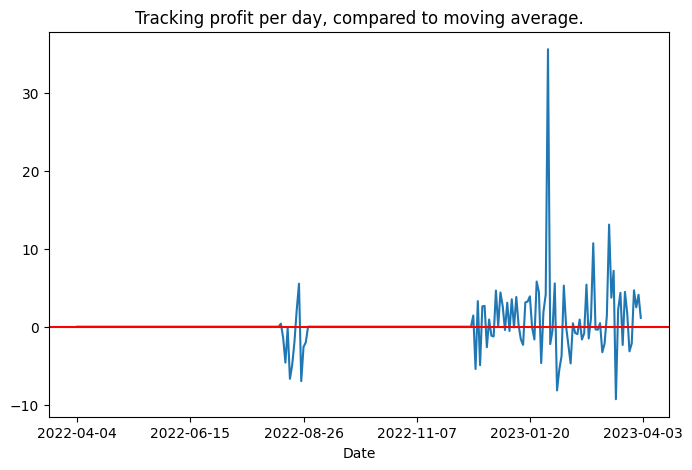

In [14]:
plt.figure(figsize=(8,5))
meta['Profit'].plot()
plt.axhline(y=0, color='red')
plt.title('Tracking profit per day, compared to moving average.')
plt.show()

Up y = 0 --> make money

Above y = 0 --> lose money

In [15]:
# Use cumsum() to display our model's performance if we follow the strategy
meta['wealth'] = meta['Profit'].cumsum()
meta.tail()

,Open,High,Low,Close,Adj Close,Volume,PriceDiff,Return,Direction,MA40,MA200,MA10,MA50,Shares_new,Close1,Profit,wealth
Date,,,,,,,,,,,,,,,,,
2023-03-28,200.149994,201.029999,197.899994,200.679993,200.679993,19127300,4.670013,0.023271,1,183.441248,149.99640,201.187998,175.111198,1,205.350006,4.670013,61.860008
2023-03-29,203.559998,205.720001,202.539993,205.350006,205.350006,18851100,2.489990,0.012126,1,184.850748,150.14530,201.947998,176.510999,1,207.839996,2.489990,64.349998
2023-03-30,203.380005,208.089996,202.820007,207.839996,207.839996,22608300,4.100006,0.019727,1,186.218748,150.36320,202.238999,178.007398,1,211.940002,4.100006,68.450004
2023-03-31,207.240005,212.169998,206.770004,211.940002,211.940002,25412000,1.130005,0.005332,1,186.797998,150.60425,203.871999,179.523199,1,213.070007,1.130005,69.580009
2023-04-03,208.839996,213.490005,208.199997,213.070007,213.070007,17908100,NaN,NaN,-1,187.461498,150.82285,205.398000,180.997199,1,NaN,NaN,NaN


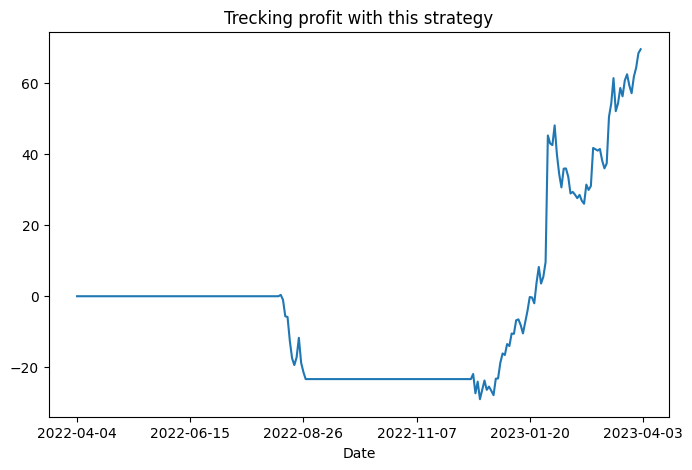

In [16]:
plt.figure(figsize=(8,5))
meta['wealth'].plot()
plt.title('Trecking profit with this strategy')
plt.show()

# Distribution impact risk in stock

PDF = Probability Density Function

CDF = Cumulative Distribtuion Function

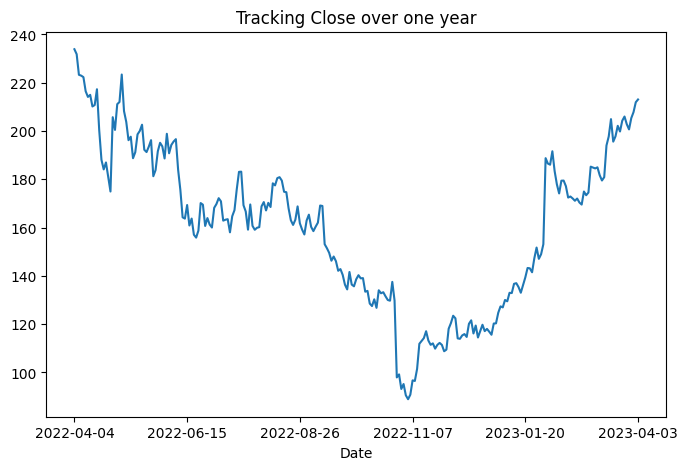

In [17]:
plt.figure(figsize=(8,5))
meta['Close'].plot()
plt.title('Tracking Close over one year')
plt.show()

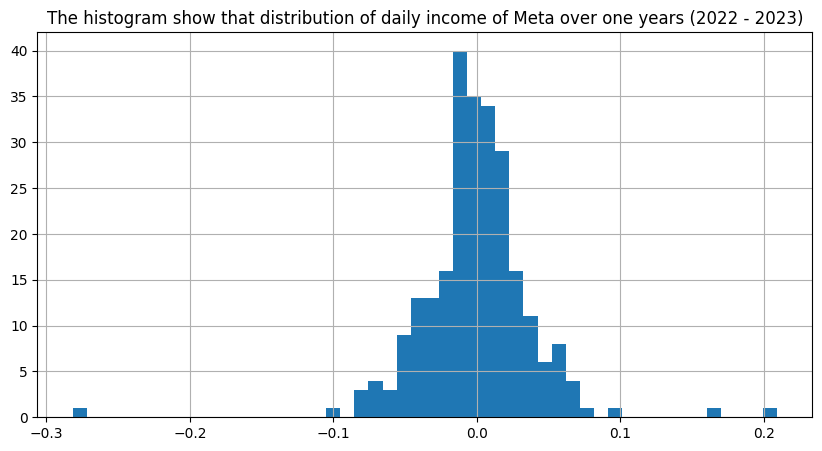

In [18]:
#Cal Log return per day
meta['LogReturn'] = np.log(meta['Close']).shift(-1) - np.log(meta['Close'])
plt.figure(figsize=(10,5))
meta['LogReturn'].hist(bins = 50)
plt.title('The histogram show that distribution of daily income of Meta over one years (2022 - 2023)')
plt.show()

In [19]:
from scipy.stats import norm

In [20]:
#Cal approximate mean and variance of the log daily return
mu = meta['LogReturn'].mean()
sigma = meta['LogReturn'].std(ddof=1)
print('Mean of Log daily return of stock in Meta company:', mu, '\n')
print('Variance of Log daily return of stock in Meta company:', sigma)

Mean of Log daily return of stock in Meta company: -0.0003729205280678443 

Variance of Log daily return of stock in Meta company: 0.03954667039385609


## What is the chance of losing over 5% in a day?

In [21]:
denMeta = pd.DataFrame()
denMeta['x'] = np.arange(meta['LogReturn'].min()-0.01, meta['LogReturn'].max()+0.01, 0.001)
denMeta['pdf'] = norm.pdf(denMeta['x'],mu,sigma)
denMeta

,x,pdf
0,-0.291794,1.629716e-11
1,-0.290794,1.962902e-11
2,-0.289794,2.362695e-11
3,-0.288794,2.842097e-11
4,-0.287794,3.416586e-11
...,...,...
507,0.215206,3.556387e-06
508,0.216206,3.097458e-06
509,0.217206,2.696027e-06
510,0.218206,2.345121e-06


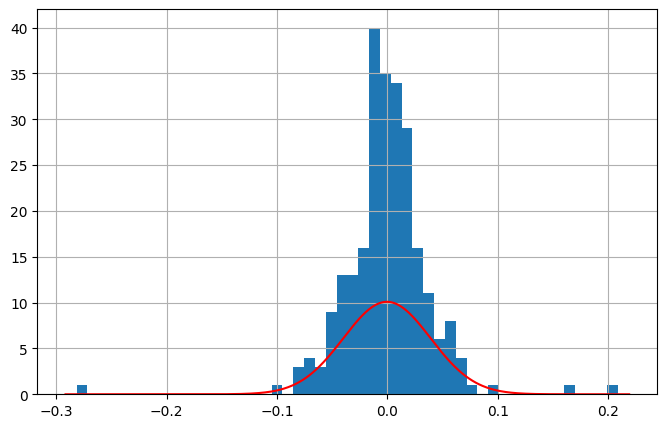

In [22]:
meta['LogReturn'].hist(bins=50, figsize=(8,5))
plt.plot(denMeta['x'],denMeta['pdf'],color='r')
plt.show()

## Calculate the probability of the stock price will drop over a certain percentage in a year

In [23]:
# probability that the stock price of meta will drop over 5% in a day
prob_return1 = norm.cdf(-0.05, mu, sigma)
print('The Probability is ', prob_return1)

The Probability is  0.1047577027880342


In [24]:
# Now is your turn, calculate the probability that the stock price of meta will drop over 10% in a day
prob_return_10 = norm.cdf(-0.1, mu, sigma)
print('The Probability is ', prob_return_10)

The Probability is  0.005880623512244633


In [25]:
# drop over 40% in 220 days
mu220 = 220*mu
sigma220 = (220**0.5) * sigma
print('The probability of dropping over 40% in 220 days is ', norm.cdf(-0.4, mu220, sigma220))

The probability of dropping over 40% in 220 days is  0.2938884033855471


In [26]:
# drop over 20% in 220 days
mu220 = 220*mu
sigma220 = (220**0.5) * sigma
drop20 = norm.cdf(-0.2,mu220,sigma220)
print('The probability of dropping over 20% in 220 days is ', drop20)

The probability of dropping over 20% in 220 days is  0.4203116094244652


## Calculate Value at risk (VaR)

In [27]:
# Value at risk(VaR)
VaR = norm.ppf(0.05, mu, sigma)
print('Single day value at risk ', VaR)

Single day value at risk  -0.06542140475925647


In [28]:
# Quatile 
# 5% quantile
print('5% quantile ', norm.ppf(0.05, mu, sigma))
# 95% quantile
print('95% quantile ', norm.ppf(0.95, mu, sigma))

5% quantile  -0.06542140475925647
95% quantile  0.06467556370312076


In [29]:
# This is your turn to calcuate the 25% and 75% Quantile of the return
# 25% quantile
q25 = norm.ppf(0.25,mu,sigma)
print('25% quantile ', q25)
# 75% quantile
q75 = norm.ppf(0.75,mu,sigma)
print('75% quantile ', q75)

25% quantile  -0.027046744363106622
75% quantile  0.026300903306970932


# Population An Sample

**Population is a group of individuals who have something in common.  
Property about a certain group --> called target population.**  

Since we cannot get information for every individual of these populations.  
--> we have to take sample which is a part of target population.

**Sample is small group of population, which is a representative of the population hence, it has to be randomly selected.**  
--> This process is called random sampling. 
 
- Without replacement: 
    a population individual can be selected only one time
    putting it back to population  
--> big population

- With replacement: 
    a randomly selected individual will be put back before the next one being selected
    a population element can be selected more than one time.  
--> small population





In [30]:
data = pd.DataFrame()

In [32]:
#Apply sample function to create sample
# False = without replacement
# True = with replacement
a_smaple_without_replacement = data['population'].sample(5, replace=False)
a_sample_with_replacement = data['population'].sample(5, replace=True)

In [33]:
a_sample_with_replacement

Date
2022-05-16    200.039993
2022-06-02    198.860001
2023-02-27    169.539993
2022-07-07    172.190002
2022-09-12    168.960007
Name: population, dtype: float64

In [34]:
a_smaple_without_replacement

Date
2022-11-01     95.199997
2022-07-01    160.029999
2022-05-31    193.639999
2022-08-17    174.850006
2022-11-21    109.860001
Name: population, dtype: float64

In [35]:
sample_length = 500
sample_variance_collection0 = [data['population'].sample(50, replace=True).var(ddof=0)
                               for i in range(sample_length)]
sample_variance_collection0 = pd.DataFrame(sample_variance_collection0, columns=['sample_variance_collection0'])

In [36]:
sample_variance_collection1 = [data['population'].sample(50,replace=True).var(ddof=1)
                               for i in range(sample_length)]
sample_variance_collection1 = pd.DataFrame(sample_variance_collection1, columns=['sample_variance_collection1'])

In [37]:
print('Population variances is', data['population'].var(ddof=0))
print('Average of sample variance with n is',sample_variance_collection0['sample_variance_collection0'].mean())
print('Average of sample  variance with n-1 is', sample_variance_collection1['sample_variance_collection1'].mean())
print('Population mean is',data['population'].mean())
print('Stand deviation of population is',data['population'].std())

Population variances is 1087.0574626055925
Average of sample variance with n is 1072.2488655692352
Average of sample  variance with n-1 is 1093.8693240128143
Population mean is 160.4729083067729
Stand deviation of population is 33.03642977768656
